# Obliczanie pierwiastków wielomianów w postaci

$f(x) = ax^3 + bx^2 + cx + d,\quad a,b,c,d \in R$


Zaczniemy od dodania potrzebnych biblotek pozwalających nam zdefiniować wielomiany w języku Julia oraz
rysować potrzebne wykresy

In [325]:
using Polynomials
using Plots

setprecision(128)

128

Zdefinijumy sobie przykładowy wielomian: $x^3 + x^2 + x + 1$ i narysujmy jego wykres.

In [326]:
f = fromroots([0 - 1im,0 + 1im,-1])

Polynomial(1 + x + x^2 + x^3)

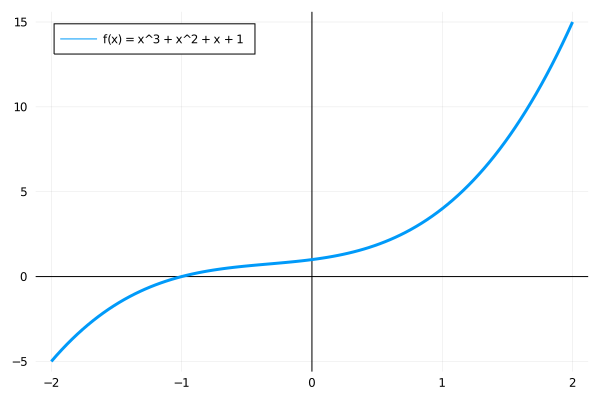

In [327]:
default(framestyle = :zerolines)
plot(f, -2, 2, label = "f(x) = x^3 + x^2 + x + 1", linewidth = 3, legend = :topleft)

# Obliczanie wartości funkcji i pochodnych

Potrzebujemy sprawnego i szybkiego algorytmu do obliczania wartości naszych wielomianów oraz ich pochodnych pierwszego stopnia. Do tego użyjemy rozszerzonego schematu Hornera danego algorytmem:

In [328]:
# Funkcja dla danej funkcji f i argumentu x zwróci parę (f(x0), f'(x0)).

function Horner(polynomial, x)
    n = length(polynomial) - 1
    
    f  = polynomial[n]
    ∂f = 0
    
    for i = n - 1:-1:0
        ∂f = f + x * ∂f
        f  = polynomial[i] + x * f
    end
    
    return f, ∂f
end

Horner (generic function with 1 method)

Sprawdźdmy poprawność działania algorytmu dla kilku przykładowych punktów

In [329]:
using Printf

println("Dla x = 0: ", Horner(f, 0))
println("Dla x = 2: ", Horner(f, 2))
println("Dla x = 4: ", Horner(f, 4))

Dla x = 0: (1, 1)
Dla x = 2: (15, 17)
Dla x = 4: (85, 57)


# Dzielenie wielomianów 3 stopnia przez wielomian (x - x0)

Jest to zwykły algorytm Hornera, do dzielenia wielominaów.

In [330]:
function divide(f, x0) 
    b = zeros(3)
    b[3] = f[3]
    
    for i = 2:-1:1
        b[i] = f[i] + x0 * b[i + 1]
    end
 
    return Polynomial(b)
end

divide (generic function with 1 method)

# Metoda wyznczania pierwiastków wielomianów kwadratowych

Przed implementacją innych metod, potrzebuję mieć algorytm numerycznie poprawny, który znajdzie pierwiastki funkcji kwadratowej. Mogę to zrobić wyznaczając wyróżnik funkcji i używając istniejących wzorów Viete'a uważając, aby nie utracić cyfr znaczących.

In [331]:
# Funkcja, dla danej funkcji f zwróci jej pierwiastki zespolone

function solveQuadratic(f)
    a = f[2]
    b = f[1]
    c = f[0]
    
    x1 = 0
    x2 = 0
    
    Δ = b * b - 4 * a * c
    
    if (Δ > 0)
        
        if (b > 0)
            x1 = (-b - sqrt(Δ)) / (2 * a)
        else
            x1 = (-b + sqrt(Δ)) / (2 * a)
        end
        x2 = c / (a * x1)
            
    elseif (Δ == 0)        
        x1 = -b / (2 * a)        
        x2 = -b / (2 * a)
    else
        
        if (b > 0)
            x1 = (-b - sqrt(-Δ)*im) / (2 * a)
        else
            x1 = (-b + sqrt(-Δ)*im) / (2 * a)
        end
        x2 = c / (a * x1)
    end
    
    return [x1, x2]
end

solveQuadratic (generic function with 1 method)

In [332]:
solveQuadratic(Polynomial([-1,0,1]))

2-element Array{Float64,1}:
  1.0
 -1.0

In [333]:
solveQuadratic(Polynomial([1,0,1]))

2-element Array{Complex{Float64},1}:
 0.0 + 1.0im
 0.0 - 1.0im

In [334]:
solveQuadratic(Polynomial([5,2,3]))

2-element Array{Complex{Float64},1}:
 -0.3333333333333333 - 1.247219128924647im
 -0.3333333333333333 + 1.2472191289246473im

In [335]:
roots(Polynomial([5,2,3]))

2-element Array{Complex{Float64},1}:
 -0.33333333333333337 - 1.2472191289246473im
 -0.33333333333333337 + 1.2472191289246473im

# Metoda Newtona

Poniżej znajduje się zaimplementowany algorytm metody Newtona

In [336]:
# Funkcja dla danej funkcji f, danego punktu startowego x0 zwróci pierwiastek z dokładnością do ε.
# Oczywiście tylko jeśli x0 będzie dostatecznie tego pierwiastka.
# Ponieważ metoda może być rozbieżna ograniczę liczbę iteracji do M.

function Newton(f, x0, ε, M, print = false)
    v = Horner(f, x0)
    
    if (abs(v[1]) < ε)
        return x0
    end
    
    for i = 1:M
        x1 = x0 - v[1] / v[2]
        v = Horner(f, x1)
        
        rε = abs((x1 - x0) / x1)
        
        if print
            @printf("Iteracja: %d, x_i = %f, błąd bezwględny = %f\n", i, x1, rε)
        end
            
        if (abs(v[1]) < ε)
            x0, x2 = solveQuadratic(divide(f, x1))
            
            return [x0, x1, x2, f(x1)]
        end
        
        x0 = x1
    end
    
    x1, x2 = solveQuadratic(divide(f, x0))
            
    return [x0, x1, x2, f(x0)]
end

Newton (generic function with 2 methods)

Przetestujmy działanie algorytmu dla kilku punktów startowych dla naszej funkcji f.

In [337]:
Newton(f, 5, 1.0e-10, 20)

4-element Array{Complex{Float64},1}:
  8.881784197001252e-16 + 1.0000000000000009im
    -1.0000000000000018 + 0.0im
  8.881784197001252e-16 - 1.0000000000000009im
 -3.552713678800504e-15 + 0.0im

In [338]:
Newton(f, -6, 1.0e-10, 20)

4-element Array{Complex{Float64},1}:
   4.440892098500626e-16 + 1.0000000000000004im
     -1.0000000000000009 + 0.0im
   4.440892098500626e-16 - 1.0000000000000004im
 -1.7763568394002513e-15 + 0.0im

In [339]:
Newton(f, 100, 1.0e-10, 20, true)

Iteracja: 1, x_i = 66.554055, błąd bezwględny = 0.502538
Iteracja: 2, x_i = 44.255989, błąd bezwględny = 0.503843
Iteracja: 3, x_i = 29.389435, błąd bezwględny = 0.505847
Iteracja: 4, x_i = 19.476583, błąd bezwględny = 0.508963
Iteracja: 5, x_i = 12.865175, błąd bezwględny = 0.513900
Iteracja: 6, x_i = 8.453046, błąd bezwględny = 0.521957
Iteracja: 7, x_i = 5.504251, błąd bezwględny = 0.535730
Iteracja: 8, x_i = 3.525977, błąd bezwględny = 0.561057
Iteracja: 9, x_i = 2.185383, błąd bezwględny = 0.613436
Iteracja: 10, x_i = 1.251379, błąd bezwględny = 0.746380
Iteracja: 11, x_i = 0.546928, błąd bezwględny = 1.288014
Iteracja: 12, x_i = -0.124919, błąd bezwględny = 5.378247
Iteracja: 13, x_i = -1.240055, błąd bezwględny = 0.899263
Iteracja: 14, x_i = -1.045616, błąd bezwględny = 0.185956
Iteracja: 15, x_i = -1.001988, błąd bezwględny = 0.043541
Iteracja: 16, x_i = -1.000004, błąd bezwględny = 0.001984
Iteracja: 17, x_i = -1.000000, błąd bezwględny = 0.000004


4-element Array{Complex{Float64},1}:
  7.781220112690335e-12 + 1.000000000007781im
    -1.0000000000155624 + 0.0im
  7.781220112690338e-12 - 1.0000000000077813im
 -3.112488045100353e-11 + 0.0im

# Metoda bisekcji

Poniżej znajduje się zaimplementowany algorytm metody Bisekcji, wyznaczający dwa pozostałe pierwiastki przy pomocy wzorów Viete'a.

In [340]:
# Funkcja, dla danej funkcji f, dwóch punktów startowych x0 <= x1 zwróci pierwiastek x0 z dokładnością do ε.
# Oraz pierwiastki x1, x2 policzone ze wzorów Viete'a
# Ponieważ metoda może być rozbieżna ograniczę liczbę iteracji do M.

function Bisection(f, x0, x1, ε, M, print = false)
    a = Horner(f, x0)[1]
    b = Horner(f, x1)[1]
    
    if (sign(a) == sign(b))
        x1, x2 = solveQuadratic(divide(f, x0))
                
        return [x0, x1, x2]
    end
    
    for i = 1:M
        x2 = ((x0 + x1) / 2)
        
        v = Horner(f, x2)[1]
        
        if print
            @printf("Iteracja: %d, x0 = %f, f(x0) = %f\n", i, x2, v)
        end
        
        if (abs(v) < ε)
            x0, x1 = solveQuadratic(divide(f, x2))
            
            return [x0, x1, x2, f(x0)]
        end
        
        if (sign(a) != sign(v))
            x1 = x2
        else
            x0 = x2
        end
    end
        
    x1, x2 = solveQuadratic(divide(f, x0))
                
    return [x0, x1, x2, f(x0)]
end

Bisection (generic function with 2 methods)

In [341]:
Bisection(f, -5, 5, 1.0e-10, 20)

4-element Array{Complex{Float64},1}:
   -1.0000038146972656 + 0.0im
    1.9073486328125e-6 + 1.0000019073522708im
    1.9073486328125e-6 - 1.0000019073522708im
 -7.629423635135968e-6 + 0.0im

In [342]:
Bisection(f, -50, 50, 1.0e-10, 20)

4-element Array{Complex{Float64},1}:
   -1.0000228881835938 + 0.0im
    1.1444091796875e-5 + 1.0000114442227626im
 1.1444091796875002e-5 - 1.0000114442227628im
 -4.577741493738685e-5 + 0.0im

In [343]:
Bisection(f, -3, 16, 1.0e-10, 20, true)

Iteracja: 1, x0 = 6.500000, f(x0) = 324.375000
Iteracja: 2, x0 = 1.750000, f(x0) = 11.171875
Iteracja: 3, x0 = -0.625000, f(x0) = 0.521484
Iteracja: 4, x0 = -1.812500, f(x0) = -3.481689
Iteracja: 5, x0 = -1.218750, f(x0) = -0.543671
Iteracja: 6, x0 = -0.921875, f(x0) = 0.144520
Iteracja: 7, x0 = -1.070313, f(x0) = -0.150860
Iteracja: 8, x0 = -0.996094, f(x0) = 0.007782
Iteracja: 9, x0 = -1.033203, f(x0) = -0.068648
Iteracja: 10, x0 = -1.014648, f(x0) = -0.029729
Iteracja: 11, x0 = -1.005371, f(x0) = -0.010800
Iteracja: 12, x0 = -1.000732, f(x0) = -0.001466
Iteracja: 13, x0 = -0.998413, f(x0) = 0.003169
Iteracja: 14, x0 = -0.999573, f(x0) = 0.000854
Iteracja: 15, x0 = -1.000153, f(x0) = -0.000305
Iteracja: 16, x0 = -0.999863, f(x0) = 0.000275
Iteracja: 17, x0 = -1.000008, f(x0) = -0.000015
Iteracja: 18, x0 = -0.999935, f(x0) = 0.000130
Iteracja: 19, x0 = -0.999971, f(x0) = 0.000057
Iteracja: 20, x0 = -0.999990, f(x0) = 0.000021


4-element Array{Complex{Float64},1}:
    -1.0000076293945312 + 0.0im
      3.814697265625e-6 + 1.0000038147118175im
  3.8146972656249987e-6 - 1.0000038147118173im
 -1.5258905478265916e-5 + 0.0im

# Metoda Bairstowa

Poniżej znajduje się zaimplementowany algorytm metody Bairstowa.

In [344]:
# Funkcja, dla danej funkcji f, startowych przybliżeń v, u zwraca wszystkie pierwiastki 
# wielomianu trzeciego stopnia. Maksymalna liczba iteracji to M. 

function Bairstow(f, u, v, M)
    n = length(f)
    
    b = zeros(n)
    c = zeros(n)
    
    b[n] = f[n - 1]
    c[n - 1] = f[n - 1]
    
    for j = 1:M
        b[n-1] = f[n - 2] + u * b[n]
        for k = n - 2:-1:1
            b[k] = f[k - 1] + u * b[k + 1] + v * b[k + 2]
            c[k] = b[k + 1] + u * c[k + 1] + v * c[k + 2]
        end
        
        J = c[1] * c[3] - c[2] * c[2]
        u = u + (c[2] * b[2] - c[3] * b[1]) / J
        v = v + (c[2] * b[1] - c[1] * b[2]) / J
    end
    
    quadratic = Polynomial([-v, -u, 1])
    x0, x1 = solveQuadratic(quadratic)
    
    if (x0 != 0 && x1 != 0)
        x2 = -f[0] / (f[3] * x0 * x1)
    else
        x2 = -f[2] / f[3] - x0 - x1
    end
    
    return [x0, x1, x2, f(x0)]
    
end

Bairstow (generic function with 1 method)

In [345]:
Bairstow(f, 1, 1, 40)

4-element Array{Complex{Float64},1}:
 3.5578623851139984e-17 + 1.0im
 3.5578623851139984e-17 - 1.0im
                   -1.0 + 0.0im
  2.531676950281814e-33 + 7.115724770227997e-17im

In [346]:
roots(f)

3-element Array{Complex{Float64},1}:
    -1.0000000000000009 + 0.0im
 -7.771561172376096e-16 - 0.9999999999999998im
 -7.771561172376096e-16 + 0.9999999999999998im

In [347]:
Bairstow(f, -0.5, -0.5, 40)

4-element Array{Complex{Float64},1}:
  5.442873907761786e-17 + 1.0im
  5.442873907761786e-17 - 1.0im
                   -1.0 + 0.0im
 5.9249752751588115e-33 + 1.0885747815523573e-16im

# Wzory Cardano

In [348]:
function Cardano(f)
    a = f[3]
    b = f[2]
    c = f[1]
    d = f[0]
    
    Q = (3 * a * c - b * b) / (9 * a * a)
    R = (9 * a * b * c - 27 * a * a * d - 2 * b * b * b) / (54 * a * a * a)
    
    discriminant = Q * Q * Q + R * R
    S = 0
    T = 0
    
    if (discriminant >= 0)
        S = cbrt(R + sqrt(discriminant))
        T = cbrt(R - sqrt(discriminant))
    else
        S = (R + sqrt(discriminant + 0im))^(1/3)
        T = (R - sqrt(discriminant + 0im))^(1/3)
    end
    
    x0 = S + T - b / (3 * a)
    x1 = -(S + T) / 2 - b / (3 * a) + (im * sqrt(3)) / 2 * (S - T)
    x2 = -(S + T) / 2 - b / (3 * a) - (im * sqrt(3)) / 2 * (S - T)
    
    return [x0, x1, x2]
end

Cardano (generic function with 1 method)

In [349]:
Cardano(f)

3-element Array{Complex{Float64},1}:
                  -1.0 + 0.0im
 5.551115123125783e-17 + 0.9999999999999999im
 5.551115123125783e-17 - 0.9999999999999999im

# Testy numeryczne

Zaimplementowałem trzy różne metody szukania pierwiastków wielomianów trzeciego stopnia. Ponieważ metoda Newtona i bisekcji potrzebują mieć sensowne dane wejściowe, aby znaleźć chociaż jeden pierwiastek, to pokażę jak szybko i z jakim błędem są w stanie go znaleźć, a potem używając schematu Hornera wyznacze pozostałe dwa pierwiastki. Na początek kilka testów przygotowanych, a później kilka wielomianów wylosowanych za pomocą Julii.

Zdefiniowałem cztery funkcje testujące dla każdej metody. Wszystkie pokazują ile cyfr znaczących wyznaczyły dobrze.

In [350]:
# Wyświetla ilość cyfr znaczących

function TestBairstow(f, v, u, MaxM, r1, r2, r3)
    
    function significantDigits(x)
        if (x == 0)
            return 20
        end
        
        return min(20, max(0, round(-log10(abs(x)))))
    end
    
    x0 = zeros(MaxM)
    x1 = zeros(MaxM)
    x2 = zeros(MaxM)
    
    for i = 1:MaxM
        b = Bairstow(f, u, v, i)
    
        x0[i] = significantDigits(abs(r1 - b[1]))
        x1[i] = significantDigits(abs(r2 - b[2]))
        x2[i] = significantDigits(abs(r3 - b[3]))        
    end    
    
    default(framestyle = :zerolines)
    plot([x0, x1, x2], label = ["x0" "x1" "x2"], 
        linewidth = 3, xlabel = "Iteracja", ylabel="Liczba cyfr znaczących", legend = :topleft)    
end

TestBairstow (generic function with 1 method)

In [351]:
function getInitialGuess(f, df)
    a = f[3]
    
    if (typeof(solveQuadratic(df)[1])<:Real)
    
        d0 = sort(solveQuadratic(df))

        f1 = Horner(f, d0[1] - 0.5)[1]
        f2 = Horner(f, d0[2] + 0.5)[1]

        if (sign(a) == sign(f1))
            return d0[1] - 0.5
        elseif (sign(a) != sign(f2))
            return d0[2] + 0.5
        else
            return d0[2] + 0.1
        end
    end
    
    return -0.350001
end

getInitialGuess (generic function with 1 method)

In [352]:
# Wyświetla ilość cyfr znaczących

function TestNewton(f, x_0, ε, MaxM, r1, r2, r3)
    
    function significantDigits(x)
        if (x == 0)
            return 20
        end
        
        return min(20, max(0, round(-log10(abs(x)))))
    end
    
    x0 = zeros(MaxM)
    x1 = zeros(MaxM)
    x2 = zeros(MaxM)
    
    for i = 1:MaxM
        b = Newton(f, x_0, ε, i)
    
        x0[i] = significantDigits(abs(r1 - b[1]))
        x1[i] = significantDigits(abs(r2 - b[2]))
        x2[i] = significantDigits(abs(r3 - b[3]))        
    end    
    
    default(framestyle = :zerolines)
    plot([x0, x1, x2], label = ["x0" "x1" "x2"], 
        linewidth = 3, xlabel = "Iteracja", ylabel="Liczba cyfr znaczących", legend = :topleft)    
end

TestNewton (generic function with 1 method)

In [353]:
# Wyświetla ilość cyfr znaczących

function TestBisection(f, x_0, x_1, ε, MaxM, r1, r2, r3)
    
    function significantDigits(x)
        if (x == 0)
            return 20
        end
        
        return min(20, max(0, round(-log10(abs(x)))))
    end
    
    x0 = zeros(MaxM)
    x1 = zeros(MaxM)
    x2 = zeros(MaxM)
    
    for i = 1:MaxM
        b = Bisection(f, x_0, x_1, ε, i)

        x0[i] = significantDigits(abs(r1 - b[1]))
        x1[i] = significantDigits(abs(r2 - b[2]))
        x2[i] = significantDigits(abs(r3 - b[3])) 
    end    
    
    default(framestyle = :zerolines)
    plot([x0, x1, x2], label = ["x0" "x1" "x2"], 
        linewidth = 3, xlabel = "Iteracja", ylabel="Liczba cyfr znaczących", legend = :topleft)    
end

TestBisection (generic function with 1 method)

In [354]:
function TestCardano(f, r1, r2, r3)
    
    x = Cardano(f)
    
    println("Błąd względny x0: ", abs(x[1] - r1))
    println("Błąd względny x1: ", abs(x[2] - r2))
    println("Błąd względny x2: ", abs(x[3] - r3))
    
end

TestCardano (generic function with 1 method)

### Test 1

Na początek prosta funkcja

##### $f(x) = x^3 - 2x^2 - 8x$

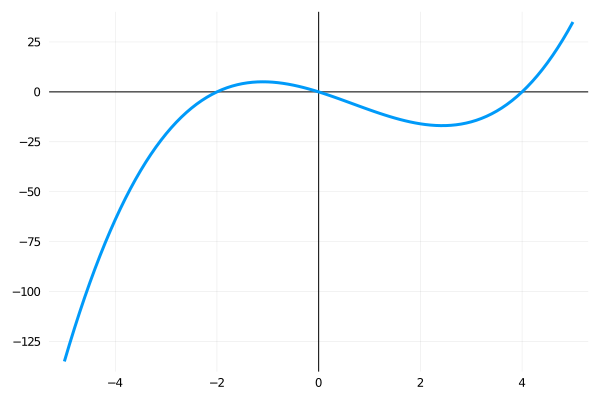

In [355]:
f = fromroots([-2, 0, 4])
df = Polynomial([-8, -4, 3])

default(framestyle = :zerolines)

M = 40
ε = 1.0e-20
x_0 = getInitialGuess(f, df)

plot(f, -5, 5, linewidth = 3, label = false)

In [356]:
Newton(f, x_0, ε, 40, true)

Iteracja: 1, x_i = -2.193239, błąd bezwględny = 0.271777
Iteracja: 2, x_i = -2.020598, błąd bezwględny = 0.085441
Iteracja: 3, x_i = -2.000277, błąd bezwględny = 0.010159
Iteracja: 4, x_i = -2.000000, błąd bezwględny = 0.000138
Iteracja: 5, x_i = -2.000000, błąd bezwględny = 0.000000
Iteracja: 6, x_i = -2.000000, błąd bezwględny = 0.000000


4-element Array{Float64,1}:
  4.0
 -2.0
  0.0
  0.0

In [357]:
Bisection(f, 15, -10, ε, 100, true)

Iteracja: 1, x0 = 2.500000, f(x0) = -16.875000
Iteracja: 2, x0 = 8.750000, f(x0) = 446.796875
Iteracja: 3, x0 = 5.625000, f(x0) = 69.697266
Iteracja: 4, x0 = 4.062500, f(x0) = 1.539307
Iteracja: 5, x0 = 3.281250, f(x0) = -12.455292
Iteracja: 6, x0 = 3.671875, f(x0) = -6.833668
Iteracja: 7, x0 = 3.867188, f(x0) = -3.013451
Iteracja: 8, x0 = 3.964844, f(x0) = -0.831434
Iteracja: 9, x0 = 4.013672, f(x0) = 0.329997
Iteracja: 10, x0 = 3.989258, f(x0) = -0.256660
Iteracja: 11, x0 = 4.001465, f(x0) = 0.035178
Iteracja: 12, x0 = 3.995361, f(x0) = -0.111113
Iteracja: 13, x0 = 3.998413, f(x0) = -0.038061
Iteracja: 14, x0 = 3.999939, f(x0) = -0.001465
Iteracja: 15, x0 = 4.000702, f(x0) = 0.016851
Iteracja: 16, x0 = 4.000320, f(x0) = 0.007691
Iteracja: 17, x0 = 4.000130, f(x0) = 0.003113
Iteracja: 18, x0 = 4.000034, f(x0) = 0.000824
Iteracja: 19, x0 = 3.999987, f(x0) = -0.000320
Iteracja: 20, x0 = 4.000010, f(x0) = 0.000252
Iteracja: 21, x0 = 3.999999, f(x0) = -0.000034
Iteracja: 22, x0 = 4.000005

4-element Array{Float64,1}:
 -2.0
 -0.0
  4.0
  0.0

In [358]:
Bairstow(f, 1, 1, 1)

4-element Array{Float64,1}:
  -3.14625657737552
   2.860542291661234
  -0.0
 -25.77238332178403

In [359]:
Bairstow(f, 1, 1, 10)

4-element Array{Float64,1}:
 -2.0
 -2.1849872483011657e-20
  0.0
  0.0

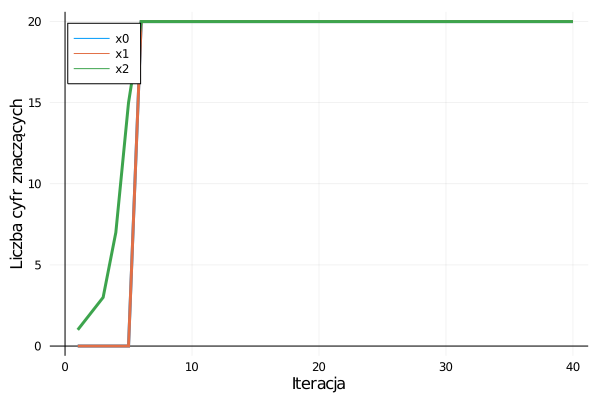

In [360]:
TestNewton(f, x_0, ε, M, 4, -2, 0)

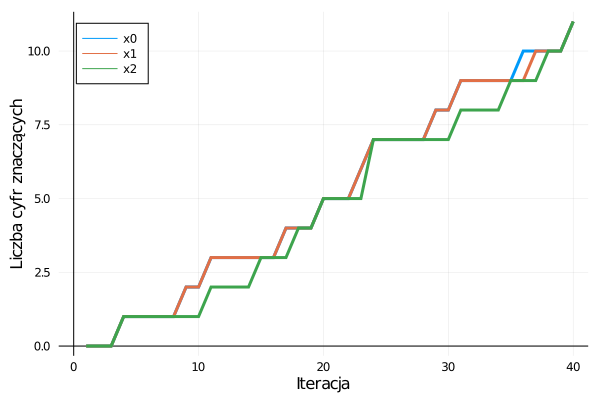

In [361]:
TestBisection(f, 15, -10, ε, M, 4, -2, 0)

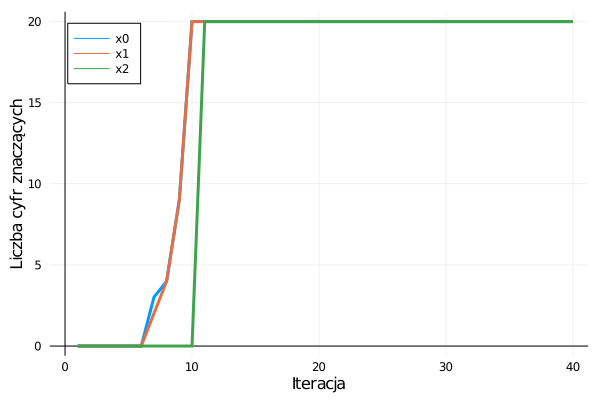

In [362]:
TestBairstow(f, 1, 1, M, -2, 0, 4)

In [363]:
TestCardano(f, 4, -2, 0)

Błąd względny x0: 0.0
Błąd względny x1: 0.0
Błąd względny x2: 0.0


### Test 2

Funkcja, która ma miejsca zerowe odległe od 0, oraz podwójny pierwiastek. 

$f(x) = x^3 + 2x^2 + 3815x - 88200$

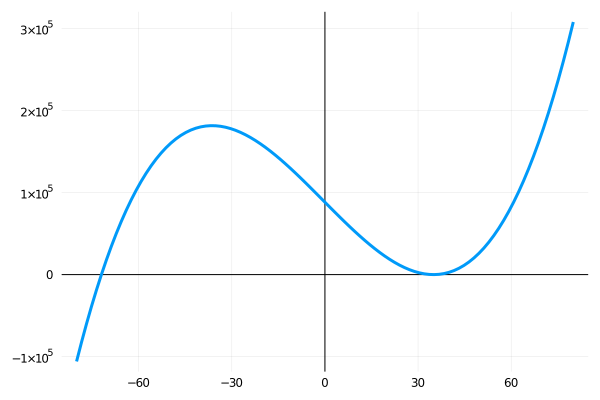

In [403]:
f = fromroots([35, 35, -72])
df = Polynomial([3815, 4, 3])

default(framestyle = :zerolines)

M = 40
ε = 1.0e-12
x_0 = getInitialGuess(f, df)

plot(f, -80, 80, linewidth = 3, label = false)

In [404]:
Newton(f, x_0, ε, 40, true)

Iteracja: 1, x_i = 23.112969, błąd bezwględny = 1.015143
Iteracja: 2, x_i = 29.452645, błąd bezwględny = 0.215250
Iteracja: 3, x_i = 32.304285, błąd bezwględny = 0.088274
Iteracja: 4, x_i = 33.669788, błąd bezwględny = 0.040556
Iteracja: 5, x_i = 34.339107, błąd bezwględny = 0.019491
Iteracja: 6, x_i = 34.670583, błąd bezwględny = 0.009561
Iteracja: 7, x_i = 34.835546, błąd bezwględny = 0.004735
Iteracja: 8, x_i = 34.917837, błąd bezwględny = 0.002357
Iteracja: 9, x_i = 34.958934, błąd bezwględny = 0.001176
Iteracja: 10, x_i = 34.979471, błąd bezwględny = 0.000587
Iteracja: 11, x_i = 34.989736, błąd bezwględny = 0.000293
Iteracja: 12, x_i = 34.994868, błąd bezwględny = 0.000147
Iteracja: 13, x_i = 34.997434, błąd bezwględny = 0.000073
Iteracja: 14, x_i = 34.998717, błąd bezwględny = 0.000037
Iteracja: 15, x_i = 34.999359, błąd bezwględny = 0.000018
Iteracja: 16, x_i = 34.999679, błąd bezwględny = 0.000009
Iteracja: 17, x_i = 34.999840, błąd bezwględny = 0.000005
Iteracja: 18, x_i = 34.

4-element Array{Float64,1}:
 -72.0
  35.00000000032811
  34.99999999967189
  -1.9895119090292067e-12

In [405]:
Bisection(f, 100, -100, ε, 100, true)

Iteracja: 1, x0 = 0.000000, f(x0) = 88200.000000
Iteracja: 2, x0 = -50.000000, f(x0) = 158950.000000
Iteracja: 3, x0 = -75.000000, f(x0) = -36300.000000
Iteracja: 4, x0 = -62.500000, f(x0) = 90309.375000
Iteracja: 5, x0 = -68.750000, f(x0) = 34983.203125
Iteracja: 6, x0 = -71.875000, f(x0) = 1427.783203
Iteracja: 7, x0 = -73.437500, f(x0) = -16903.118896
Iteracja: 8, x0 = -72.656250, f(x0) = -7605.850983
Iteracja: 9, x0 = -72.265625, f(x0) = -3056.258488
Iteracja: 10, x0 = -72.070313, f(x0) = -806.066144
Iteracja: 11, x0 = -71.972656, f(x0) = 312.898611
Iteracja: 12, x0 = -72.021484, f(x0) = -246.073397
Iteracja: 13, x0 = -71.997070, f(x0) = 33.540155
Iteracja: 14, x0 = -72.009277, f(x0) = -106.234728
Iteracja: 15, x0 = -72.003174, f(x0) = -36.339314
Iteracja: 16, x0 = -72.000122, f(x0) = -1.397586
Iteracja: 17, x0 = -71.998596, f(x0) = 16.071783
Iteracja: 18, x0 = -71.999359, f(x0) = 7.337223
Iteracja: 19, x0 = -71.999741, f(x0) = 2.969849
Iteracja: 20, x0 = -71.999931, f(x0) = 0.7861

4-element Array{Float64,1}:
  35.0
  35.0
 -72.0
   0.0

In [406]:
Bairstow(f, 1, 1, 1)

4-element Array{Float64,1}:
     75.91167528178869
    -48.84260149842918
     23.788180301631794
 247569.41096827542

In [407]:
Bairstow(f, 1, 1, 70)

4-element Array{Float64,1}:
 -72.0
  34.999999981871234
  35.000000018128766
   0.0

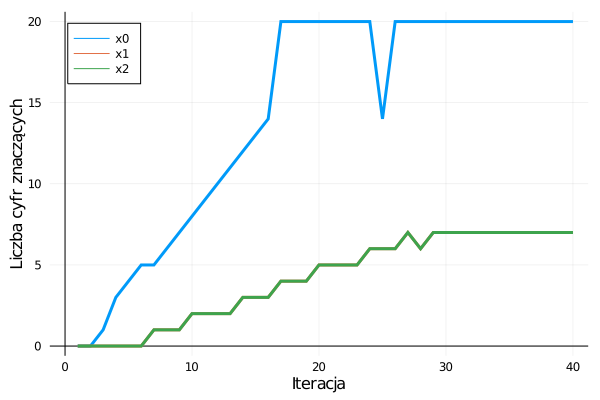

In [412]:
TestBairstow(f, 0.1, 0.1, M, -72, 35, 35)

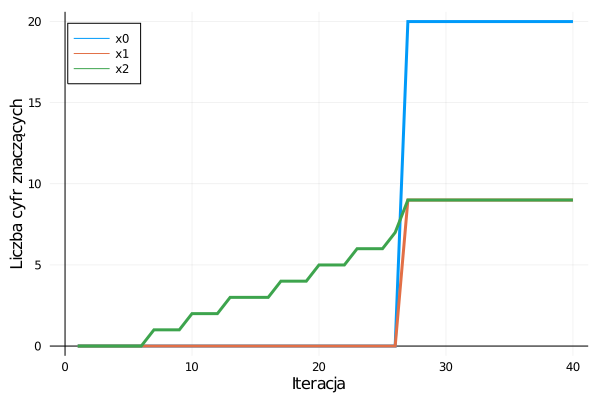

In [370]:
TestNewton(f, x_0, ε, M, -72, 35, 35)

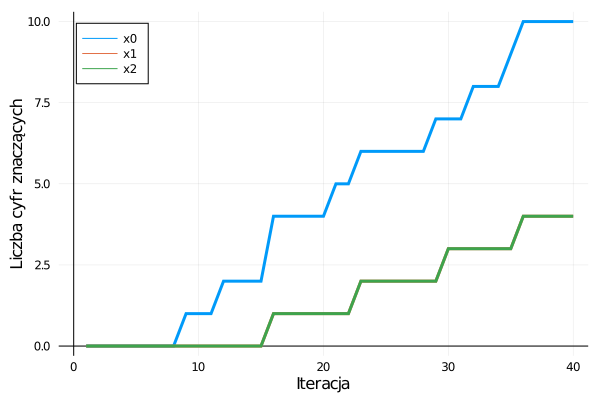

In [371]:
TestBisection(f, -100, 100, ε, M, -72, 35, 35)

In [372]:
TestCardano(f, -72, 35, 35)

Błąd względny x0: 0.0
Błąd względny x1: 0.0
Błąd względny x2: 0.0


### Test 3

Funkcja mająca 2 pierwiastki zespolone i jeden oddalony od 0

$f(x) = x^3 - 51x^2 + 281.25x - 506.25$

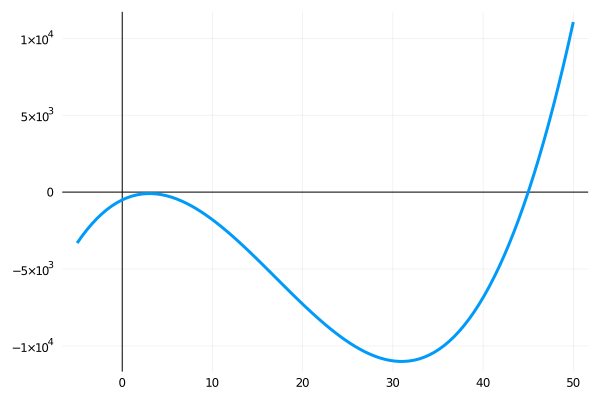

In [373]:
f = fromroots([3 - 1.5im, 3 + 1.5im, 45])
df = Polynomial([281.25, -102, 3])

default(framestyle = :zerolines)

M = 40
ε = 1.0e-12
x_0 = getInitialGuess(f, df)

plot(f, -5, 50, linewidth = 3, label = false)

In [374]:
Newton(f, x_0, ε, 40, true)

Iteracja: 1, x_i = 289.196112, błąd bezwględny = 0.891170
Iteracja: 2, x_i = 198.968587, błąd bezwględny = 0.453476
Iteracja: 3, x_i = 139.088171, błąd bezwględny = 0.430521
Iteracja: 4, x_i = 99.598220, błąd bezwględny = 0.396493
Iteracja: 5, x_i = 73.967013, błąd bezwględny = 0.346522
Iteracja: 6, x_i = 58.015900, błąd bezwględny = 0.274944
Iteracja: 7, x_i = 49.178483, błąd bezwględny = 0.179701
Iteracja: 8, x_i = 45.639736, błąd bezwględny = 0.077537
Iteracja: 9, x_i = 45.018615, błąd bezwględny = 0.013797
Iteracja: 10, x_i = 45.000016, błąd bezwględny = 0.000413
Iteracja: 11, x_i = 45.000000, błąd bezwględny = 0.000000
Iteracja: 12, x_i = 45.000000, błąd bezwględny = 0.000000


4-element Array{Complex{Float64},1}:
  3.0 + 1.5im
 45.0 + 0.0im
  3.0 - 1.5im
  0.0 + 0.0im

In [375]:
Bisection(f, -50, 100, ε, 20, true)

Iteracja: 1, x0 = 25.000000, f(x0) = -9725.000000
Iteracja: 2, x0 = 62.500000, f(x0) = 61993.750000
Iteracja: 3, x0 = 43.750000, f(x0) = -2078.515625
Iteracja: 4, x0 = 53.125000, f(x0) = 20432.470703
Iteracja: 5, x0 = 48.437500, f(x0) = 7104.681396
Iteracja: 6, x0 = 46.093750, f(x0) = 2033.632660
Iteracja: 7, x0 = 44.921875, f(x0) = -137.476063
Iteracja: 8, x0 = 45.507813, f(x0) = 918.716156
Iteracja: 9, x0 = 45.214844, f(x0) = 383.354948
Iteracja: 10, x0 = 45.068359, f(x0) = 121.132598
Iteracja: 11, x0 = 44.995117, f(x0) = -8.622265
Iteracja: 12, x0 = 45.031738, f(x0) = 56.142386
Iteracja: 13, x0 = 45.013428, f(x0) = 23.731884
Iteracja: 14, x0 = 45.004272, f(x0) = 7.547768
Iteracja: 15, x0 = 44.999695, f(x0) = -0.539009
Iteracja: 16, x0 = 45.001984, f(x0) = 3.503939
Iteracja: 17, x0 = 45.000839, f(x0) = 1.482355
Iteracja: 18, x0 = 45.000267, f(x0) = 0.471646
Iteracja: 19, x0 = 44.999981, f(x0) = -0.033689
Iteracja: 20, x0 = 45.000124, f(x0) = 0.218977


4-element Array{Complex{Float64},1}:
    44.99998092651367 + 0.0im
    3.000009536743164 + 1.4997329475100116im
   3.0000095367431636 - 1.4997329475100114im
 -0.03368851466803574 + 0.0im

In [376]:
Bairstow(f, 1, 1, 1)

4-element Array{Float64,1}:
    7.695387376234613
   -1.707792924898198
  -38.521158487530165
 -906.3775868246835

In [377]:
Bairstow(f, 1, 1, 10)

4-element Array{Complex{Float64},1}:
  3.0 + 1.5im
  3.0 - 1.5im
 45.0 - 0.0im
  0.0 + 0.0im

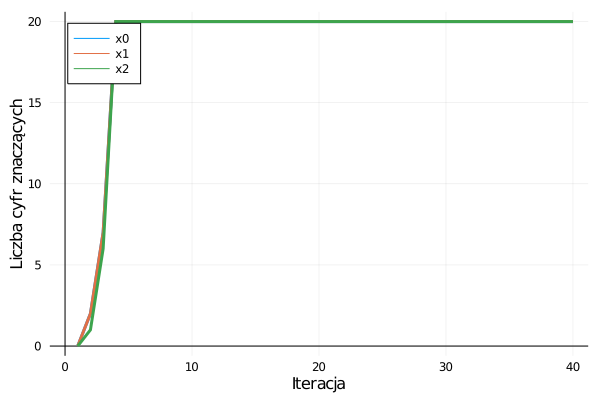

In [378]:
TestBairstow(f, 1, 1, M, 3 + 1.5im, 3 - 1.5im, 45)

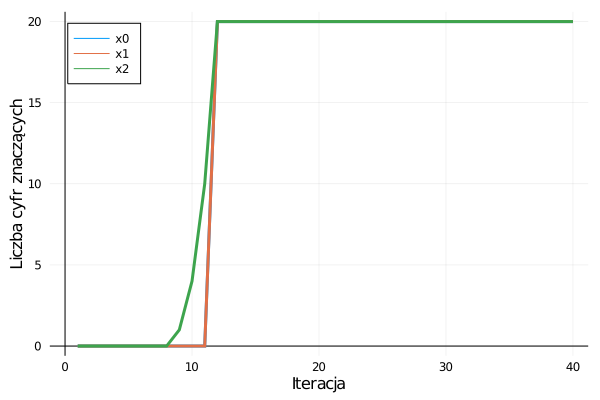

In [379]:
TestNewton(f, x_0, ε, M, 3 + 1.5im, 45, 3 - 1.5im)

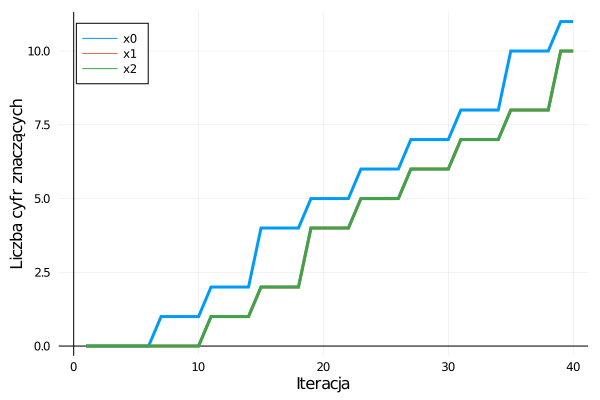

In [380]:
TestBisection(f, -50, 100, ε, M, 45, 3 + 1.5im, 3 - 1.5im)

In [381]:
TestCardano(f, 45, 3 + 1.5im, 3 - 1.5im)

Błąd względny x0: 0.0
Błąd względny x1: 8.881784197001252e-16
Błąd względny x2: 8.881784197001252e-16


### Test 4

Funkcja, która ma pierwiastki rzeczywiste bardzo blisko siebie

$ f(x) = x^3 + 2.3699500000000002x^2 - 38.976263499999995x + 68.71088465$

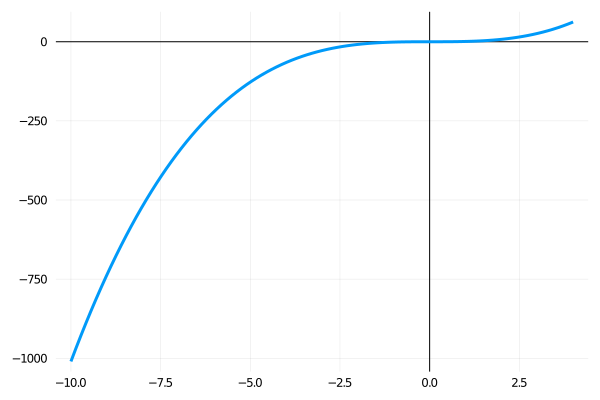

In [382]:
f = fromroots([0, 0.1, 0])
df = Polynomial([-38.976263499999995, 4.7399000000000004, 3])

default(framestyle = :zerolines)

M = 40
ε = 1.0e-18
x_0 = getInitialGuess(f, df)

plot(f, -10, 4, linewidth = 3, label = false)

In [383]:
Newton(f, x_0, ε, 15, true)

Iteracja: 1, x_i = 2.011380, błąd bezwględny = 0.491525
Iteracja: 2, x_i = 1.352412, błąd bezwględny = 0.487254
Iteracja: 3, x_i = 0.913295, błąd bezwględny = 0.480805
Iteracja: 4, x_i = 0.620850, błąd bezwględny = 0.471041
Iteracja: 5, x_i = 0.426347, błąd bezwględny = 0.456206
Iteracja: 6, x_i = 0.297402, błąd bezwględny = 0.433572
Iteracja: 7, x_i = 0.212590, błąd bezwględny = 0.398950
Iteracja: 8, x_i = 0.157914, błąd bezwględny = 0.346239
Iteracja: 9, x_i = 0.124505, błąd bezwględny = 0.268334
Iteracja: 10, x_i = 0.106921, błąd bezwględny = 0.164452
Iteracja: 11, x_i = 0.100793, błąd bezwględny = 0.060799
Iteracja: 12, x_i = 0.100012, błąd bezwględny = 0.007810
Iteracja: 13, x_i = 0.100000, błąd bezwględny = 0.000123
Iteracja: 14, x_i = 0.100000, błąd bezwględny = 0.000000
Iteracja: 15, x_i = 0.100000, błąd bezwględny = 0.000000


4-element Array{Float64,1}:
 -0.0
  0.1
 -0.0
  0.0

In [384]:
Bairstow(f, 1, 1, 1)

4-element Array{Complex{Float64},1}:
  0.8403361344537815 + 1.2194722186485618im
  0.8403361344537816 - 1.2194722186485618im
                -0.0 + 0.0im
 -3.0775125077218237 + 0.5649994510665355im

In [385]:
Bairstow(f, 1, 1, 40)

4-element Array{Float64,1}:
  0.1
  2.0672569550407147e-11
 -0.0
  0.0

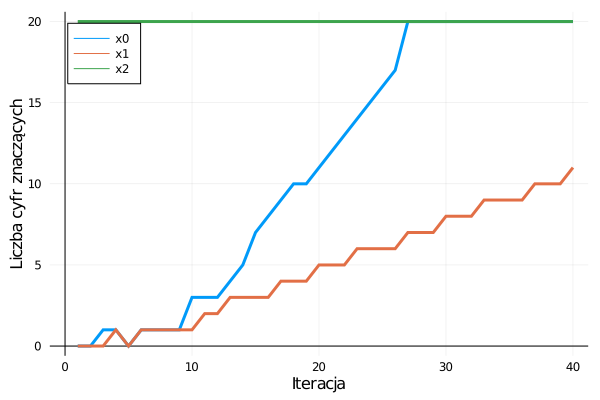

In [386]:
TestBairstow(f, 1, 1, M, 0.1, 0, 0)

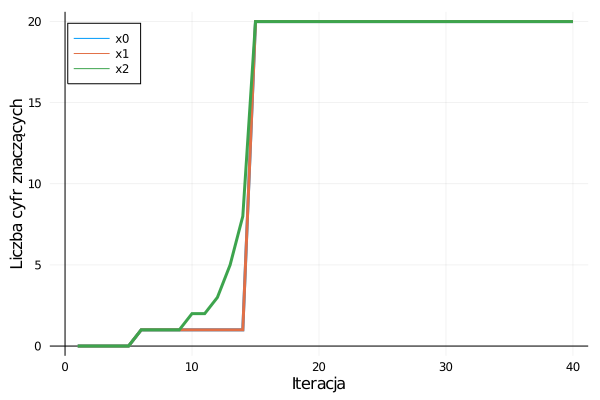

In [387]:
TestNewton(f, x_0, ε, M, 0, 0.1, 0)

In [388]:
TestCardano(f, 0.1, 0, 0)

Błąd względny x0: 0.0
Błąd względny x1: 2.3629366184170625e-10
Błąd względny x2: 2.3629364796391844e-10


### Test 5

Funkcja, o wybranych współczynnikach tak, aby oblczenia były 'niebezpieczne' numerycznie

$f(x) = x^3 + 1.0000001038583122x^2 + 0.33333364701740337x + 1.6666667812898837$

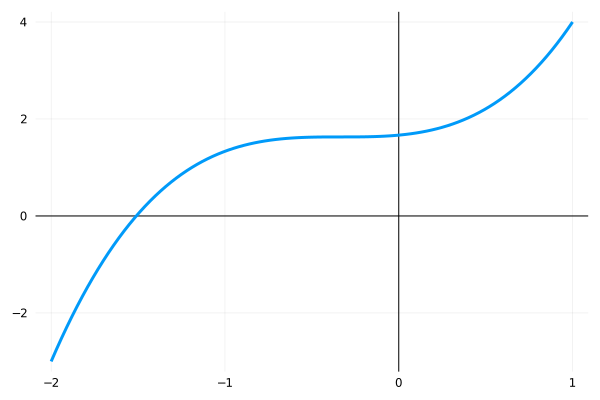

In [389]:
df = Polynomial([0.33333364701740337, 2.0000002077166243, 3])
f = fromroots([-1.5101160823533357 + 0.0im, 
                0.2550579892475119 - 1.0191238453343947im, 
                0.2550579892475119 + 1.0191238453343947im])

default(framestyle = :zerolines)

M = 40
ε = 1.0e-18
x_0 = getInitialGuess(f, df)

plot(f, -2, 1, linewidth = 3, label = false)

In [390]:
Newton(f, x_0, ε, 25, true)

Iteracja: 1, x_i = -1955.100170, błąd bezwględny = 0.999821
Iteracja: 2, x_i = -1303.511225, błąd bezwględny = 0.499872
Iteracja: 3, x_i = -869.118595, błąd bezwględny = 0.499808
Iteracja: 4, x_i = -579.523508, błąd bezwględny = 0.499712
Iteracja: 5, x_i = -386.460118, błąd bezwględny = 0.499569
Iteracja: 6, x_i = -257.751194, błąd bezwględny = 0.499353
Iteracja: 7, x_i = -171.945248, błąd bezwględny = 0.499031
Iteracja: 8, x_i = -114.741295, błąd bezwględny = 0.498547
Iteracja: 9, x_i = -76.605349, błąd bezwględny = 0.497824
Iteracja: 10, x_i = -51.181437, błąd bezwględny = 0.496741
Iteracja: 11, x_i = -34.232279, błąd bezwględny = 0.495122
Iteracja: 12, x_i = -22.933103, błąd bezwględny = 0.492702
Iteracja: 13, x_i = -15.400910, błąd bezwględny = 0.489075
Iteracja: 14, x_i = -10.380777, błąd bezwględny = 0.483599
Iteracja: 15, x_i = -7.037010, błąd bezwględny = 0.475169
Iteracja: 16, x_i = -4.814539, błąd bezwględny = 0.461617
Iteracja: 17, x_i = -3.347854, błąd bezwględny = 0.438097

4-element Array{Complex{Float64},1}:
    -1.510116082353336 + 0.0im
    0.2550579892475119 + 1.0191238453343947im
    0.2550579892475119 - 1.0191238453343947im
 -2.97379159244366e-16 + 0.0im

In [391]:
Bairstow(f, 1, 1, 1)

4-element Array{Float64,1}:
 -2.1962930904616655
  1.396292622672227
  0.5434780904069254
 -4.835994078624513

In [392]:
Bairstow(f, 1, 1, 25)

4-element Array{Complex{Float64},1}:
     0.2550579892475119 + 1.0191238453343947im
     0.2550579892475119 - 1.0191238453343947im
    -1.5101160823533357 + 0.0im
 -2.270393194406529e-16 - 1.995715828594631e-17im

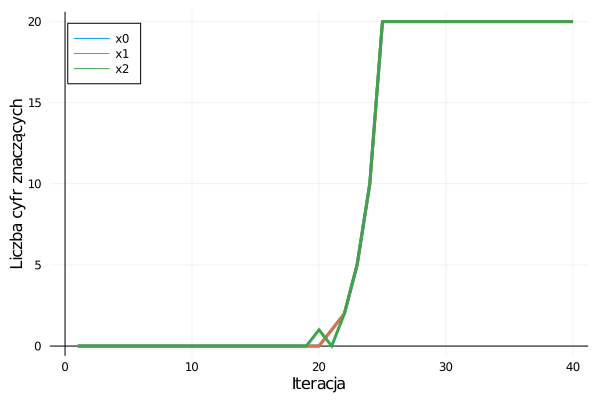

In [393]:
TestBairstow(f, 1, 1, M,
                0.2550579892475119 + 1.0191238453343947im, 
                0.2550579892475119 - 1.0191238453343947im,
                -1.5101160823533357 + 0.0im)

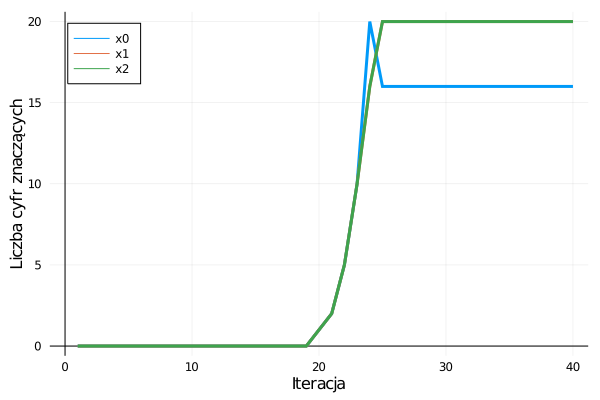

In [394]:
TestNewton(f, x_0, ε, M, 
            -1.5101160823533357 + 0.0im,
            0.2550579892475119 + 1.0191238453343947im,
            0.2550579892475119 - 1.0191238453343947im)

In [395]:
TestCardano(f, -1.510115978491691 + 0.0im, 0.2550579892475119 + 1.0191238453343947im
, 0.2550579892475119 - 1.0191238453343947im)

Błąd względny x0: 1.731027414741959e-7
Błąd względny x1: 6.924109678897218e-8
Błąd względny x2: 6.924109678897218e-8


### Test 6



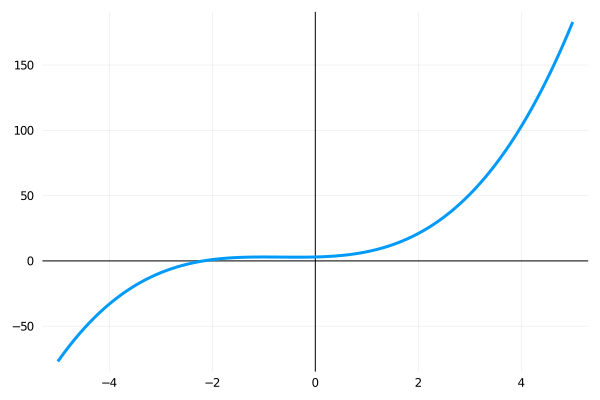

In [396]:
df = Polynomial([3, 4, 3])
f = Polynomial([3, 1, 2, 1])

default(framestyle = :zerolines)

M = 40
ε = 1.0e-12
x_0 = getInitialGuess(f, df)

plot(f, -5, 5, linewidth = 3, label = false)

In [397]:
Newton(f, x_0, ε, 50, true)

Iteracja: 1, x_i = 87.402562, błąd bezwględny = 1.004004
Iteracja: 2, x_i = 58.046868, błąd bezwględny = 0.505724
Iteracja: 3, x_i = 38.476668, błąd bezwględny = 0.508625
Iteracja: 4, x_i = 25.430146, błąd bezwględny = 0.513034
Iteracja: 5, x_i = 16.732615, błąd bezwględny = 0.519795
Iteracja: 6, x_i = 10.933890, błąd bezwględny = 0.530344
Iteracja: 7, x_i = 7.066175, błąd bezwględny = 0.547356
Iteracja: 8, x_i = 4.481818, błąd bezwględny = 0.576632
Iteracja: 9, x_i = 2.743155, błąd bezwględny = 0.633819
Iteracja: 10, x_i = 1.543788, błąd bezwględny = 0.776899
Iteracja: 11, x_i = 0.637007, błąd bezwględny = 1.423502
Iteracja: 12, x_i = -0.350756, błąd bezwględny = 2.816099
Iteracja: 13, x_i = 83.698859, błąd bezwględny = 1.004191
Iteracja: 14, x_i = 55.577758, błąd bezwględny = 0.505978
Iteracja: 15, x_i = 36.830625, błąd bezwględny = 0.509009
Iteracja: 16, x_i = 24.332810, błąd bezwględny = 0.513620
Iteracja: 17, x_i = 16.001054, błąd bezwględny = 0.520700
Iteracja: 18, x_i = 10.44608

4-element Array{Complex{Float64},1}:
    -2.174559411791341 + 0.0im
   0.08727970589567047 + 1.171312112447569im
   0.08727970589567045 - 1.1713121124475687im
 -9.721197942146932e-9 + 0.0im

In [398]:
Bairstow(f, 0.1, 0.1, 15)

4-element Array{Complex{Float64},1}:
   0.08727970514649001 + 1.1713121110008786im
   0.08727970514649001 - 1.1713121110008786im
    -2.174559410292981 + 0.0im
 1.360925295285012e-15 + 3.8459193797544795e-16im

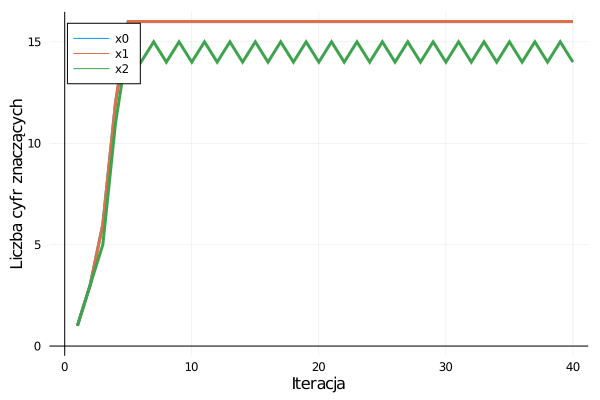

In [399]:
TestBairstow(f, 0.1, 0.1, M, 0.08727970514648989 + 1.1713121110008786im, 
                        0.08727970514648989 - 1.1713121110008786im, 
                        -2.174559410292984 + 0.0im)

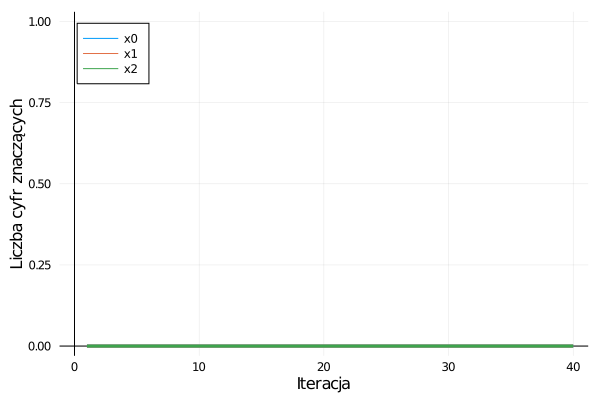

In [400]:
TestNewton(f, x_0, ε, M, -2.174559410292984 + 0.0im,
                        0.08727970514648989 - 1.1713121110008786im,
                        0.08727970514648989 + 1.1713121110008786im)

In [401]:
TestCardano(f, -2.174559410292984 + 0.0im,
            0.08727970514648989 + 1.1713121110008786im,
            0.08727970514648989 - 1.1713121110008786im)

Błąd względny x0: 1.3766765505351941e-14
Błąd względny x1: 9.90189642062563e-15
Błąd względny x2: 9.90189642062563e-15
